In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
%load_ext cython

In [216]:
%%cython -a
import cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False) 
@cython.cdivision(True)
def run_bandits(double[:, :] bandits, double epsilon=0.1):
    cdef long n_bandits, n_times, i, greedy, choice
    cdef double reward
    cdef long[:] take_greedy, random_choices, n_times_chosen
    cdef double[:] action_estimates, reward_at_stage
    
    n_bandits = bandits.shape[0]
    n_times = bandits.shape[1]
    
    action_estimates = np.zeros(n_bandits, dtype=float)
    n_times_chosen = np.zeros(n_bandits, dtype=int)
    reward_at_stage = np.zeros(n_times, dtype=float)
    
    take_greedy = 1 - np.random.binomial(1, p=epsilon, size=n_times)
    random_choices = np.random.choice(n_bandits, size=n_times)
    for i in range(n_times):
        greedy = take_greedy[i]
        if greedy:
            choice = np.argmax(action_estimates)
        else:
            choice = random_choices[i]
        n_times_chosen[choice] += 1
        reward = bandits[choice, n_times_chosen[choice] - 1]
        action_estimates[choice] += 1/(n_times_chosen[choice]) * (
            reward - action_estimates[choice])
        reward_at_stage[i] = reward
    return action_estimates, reward_at_stage

In [ ]:
def make_stationary_bandits(long n_bandits, long n_times):
    bandit_means = np.random.normal(scale=1.0, size=n_bandits).reshape((n_bandits, 1))
    bandit_draws = np.random.normal(size=(n_bandits, n_times))
    return bandit_means + bandit_draws

In [200]:
%%timeit
bandits = make_stationary_bandits(n_bandits=10, n_times=10000)
action_estimates, reward_at_stage = run_bandits(bandits)

46.7 ms ± 958 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [201]:
def bootstrap_bandits(n_bandits=10, n_times=10000, n_bootstraps=1000,
                      epsilon=0.1):
    reward_at_stages = np.zeros((n_bootstraps, n_times))
    for i in range(n_bootstraps):
        bandits = make_stationary_bandits(n_bandits, n_times)    
        _, reward_at_stage = run_bandits(bandits, epsilon=epsilon)
        reward_at_stages[i, :] = reward_at_stage
    return np.mean(reward_at_stages, axis=0)

In [202]:
mean_rewards_greedy = bootstrap_bandits(n_bootstraps=1000, epsilon=0.0)
mean_rewards_e1 = bootstrap_bandits(n_bootstraps=1000, epsilon=0.1)
mean_rewards_e01 = bootstrap_bandits(n_bootstraps=1000, epsilon=0.01)

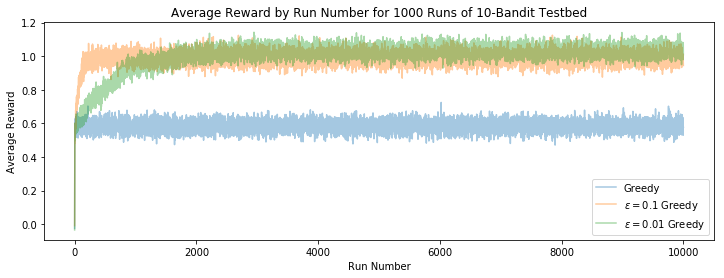

In [215]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(range(10000), mean_rewards_greedy, alpha=0.4,
        label="Greedy")
ax.plot(range(10000), mean_rewards_e1, alpha=0.4,
        label="$\epsilon=0.1$ Greedy")
ax.plot(range(10000), mean_rewards_e01, alpha=0.4,
        label="$\epsilon=0.01$ Greedy")

ax.set_xlabel("Run Number")
ax.set_ylabel("Average Reward")
ax.set_title("Average Reward by Run Number for 1000 Runs of 10-Bandit Testbed")
plt.legend()